In [1]:
import matplotlib.pyplot as plt
import nltk
from nltk import tokenize
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
import re
import seaborn as sns
import string
from collections import Counter
from wordcloud import WordCloud

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\roman.moiseev\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\roman.moiseev\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\roman.moiseev\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\roman.moiseev\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
df = pd.read_csv('data/train_essays.csv')
df.head()

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


In [3]:
df_prompts = pd.read_csv('data/train_prompts.csv')
df_prompts

,prompt_id,prompt_name,instructions,source_text
0,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ..."
1,1,Does the electoral college work?,Write a letter to your state senator in which ...,# What Is the Electoral College? by the Office...


In [4]:
df_2 = pd.read_json(r'data/train.jsonl', lines=True)
df_2.head()

,essay
0,<s>[INST]Source text: # What Is the Electoral ...
1,"<s>[INST]Source text: # In German Suburb, Life..."
2,"<s>[INST]Source text: # In German Suburb, Life..."
3,"<s>[INST]Source text: # In German Suburb, Life..."
4,<s>[INST]Source text: # What Is the Electoral ...


In [5]:
def extract_essay_content(row):
    match_prompt = re.search(r'Source text:(.*)Essay Instructions:', row['essay'], re.DOTALL)
    match_instruct = re.search(r'Essay Instructions:(.*)Essay:', row['essay'], re.DOTALL)
    match_text = re.search(r'Essay:(.*)\nDetermine', row['essay'], re.DOTALL)
    match_label = re.search(r'\[/INST\](.*)</s>', row['essay'], re.DOTALL)
    
    return pd.Series({
        'prompt': match_prompt.group(1).strip() if match_prompt else None,
        'instructions': match_instruct.group(1).strip() if match_instruct else None,
        'text': match_text.group(1).strip() if match_text else None,
        'label': match_label.group(1).strip() if match_label else None
    })
            
    
df_2[['prompt', 'instruct', 'text', 'label']] = df_2.apply(extract_essay_content, axis=1)
df_2['generated'] = np.where(df_2['label'].str.contains("was generated"), 1, 0)
df_2['prompt_id'] = np.where(df_2['prompt'].str.contains("What Is the Electoral College"), 1, 0)

In [6]:
def clean_text(text):
    text = re.sub(r'[^a-zA-Z0-9а-яА-ЯёЁ\s]', '', text) 
    text = text.lower()
    stop_words = set(nltk.corpus.stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

In [7]:
df['text'] = df['text'].apply(clean_text)
df_2['text'] = df_2['text'].apply(clean_text)

In [8]:
df = pd.concat([df[['prompt_id', 'text', 'generated']], df_2[['prompt_id', 'text', 'generated']]]).drop_duplicates()

In [9]:
# dataset comprises of 1375 human-written texts, only 3 ai-generated
df['generated'].value_counts()

generated
0    1375
1     703
Name: count, dtype: int64

In [10]:
df['prompt_id'].value_counts()

prompt_id
0    1058
1    1020
Name: count, dtype: int64

In [11]:
df.duplicated().any()

np.False_

In [12]:
df.isnull().any()

prompt_id    False
text         False
generated    False
dtype: bool

In [13]:
df_human = df[df['generated'] == 0]
df_ai = df[df['generated'] == 1]
print(df_human.info())
df_ai.head()

<class 'pandas.core.frame.DataFrame'>
Index: 1375 entries, 0 to 1377
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   prompt_id  1375 non-null   int64 
 1   text       1375 non-null   object
 2   generated  1375 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 43.0+ KB
None


,prompt_id,text,generated
704,1,essay analyze discuss prove one reason favor k...,1
740,1,strongly believe electoral college remain way ...,1
1262,0,limiting car use causes pollution increases co...,1
0,1,name address city state zip date senators name...,1
1,0,advantages limiting car usage limiting car usa...,1


In [14]:
def tokenize_and_clean_text(text):
    tokens = tokenize.word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    punct_chars = string.punctuation + "'s" + '""' + '...' + "''" + '``'
    filtered_tokens = [word.lower() for word in tokens if word not in stop_words and word not in punct_chars]
    return filtered_tokens

def lemmatize(tokens):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in tokens]

def get_mean_sent_char_length(sent_tokens):
    return np.mean([len(sent) for sent in sent_tokens])

def get_mean_sent_word_length(sent_tokens):
    return np.mean([len(sent.split()) for sent in sent_tokens])

In [15]:
df['BoW_raw'] = df['text'].apply(tokenize_and_clean_text)

In [16]:
df['text_length'] = df['BoW_raw'].apply(lambda x: len(x))

In [17]:
df['average_word_length'] = df['BoW_raw'].apply(lambda x: np.mean([len(word) for word in x if word.isalpha()]))

In [18]:
pd.options.display.float_format = '{:,.2f}'.format

In [19]:
print(df['text_length'].min())
print(df['text_length'].max())
print(df['text_length'].mean())

111
883
299.12993262752644


In [20]:
df['text_sent_length'] = df['text'].apply(tokenize.sent_tokenize).apply(len)

In [21]:
df['mean_sentence_length_chars'] = df['text'].apply(tokenize.sent_tokenize).apply(get_mean_sent_char_length)

In [22]:
df['mean_sentence_length_words'] = df['text'].apply(tokenize.sent_tokenize).apply(get_mean_sent_word_length)

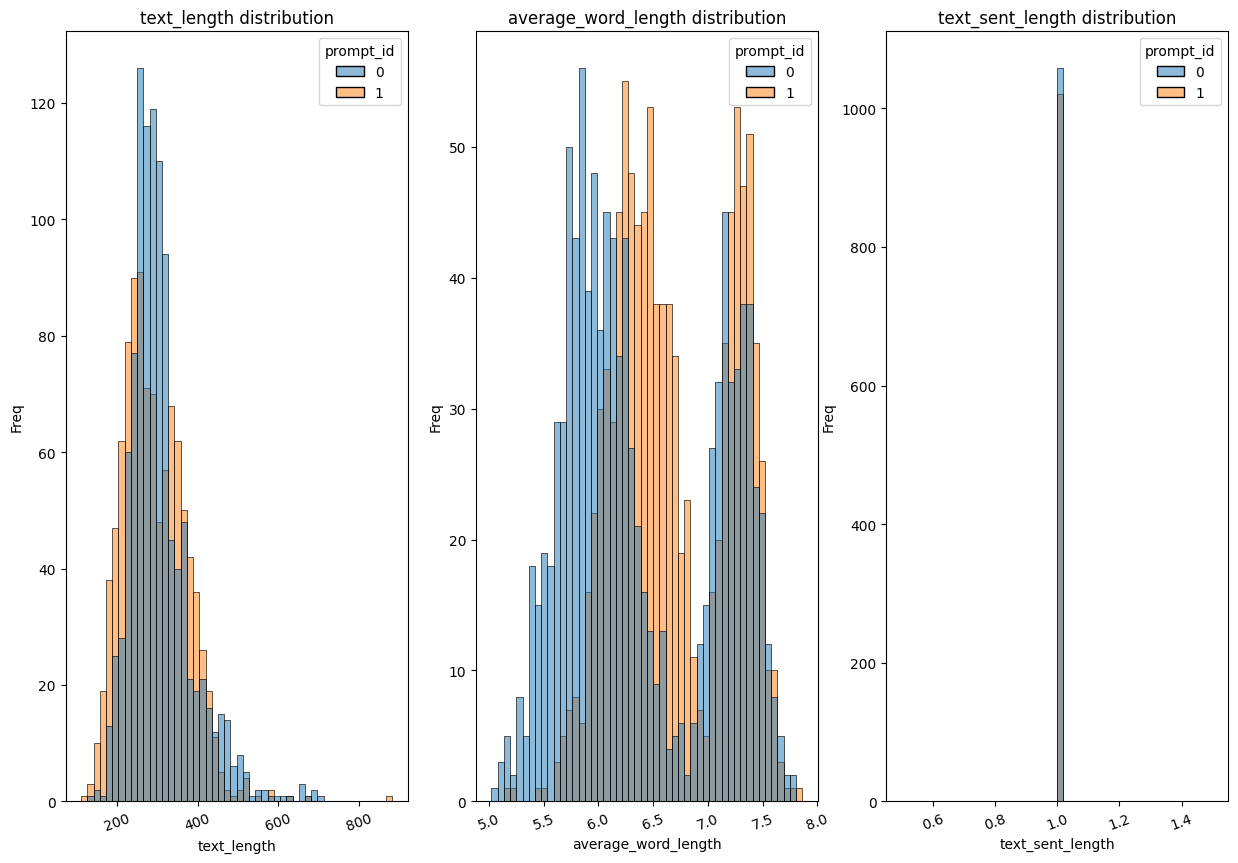

In [23]:
num_cols = df[['text_length', 'average_word_length', 'text_sent_length']].columns
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 10))
for ax, col in zip(axes.flatten(), num_cols):
    sns.histplot(data=df, x=df[col], hue='prompt_id', ax=ax, bins=50)
    ax.set_title(f'{col} distribution')
    ax.set_xlabel(f'{col}')
    ax.set_ylabel('Freq')
    ax.tick_params(axis='x', labelrotation=20)

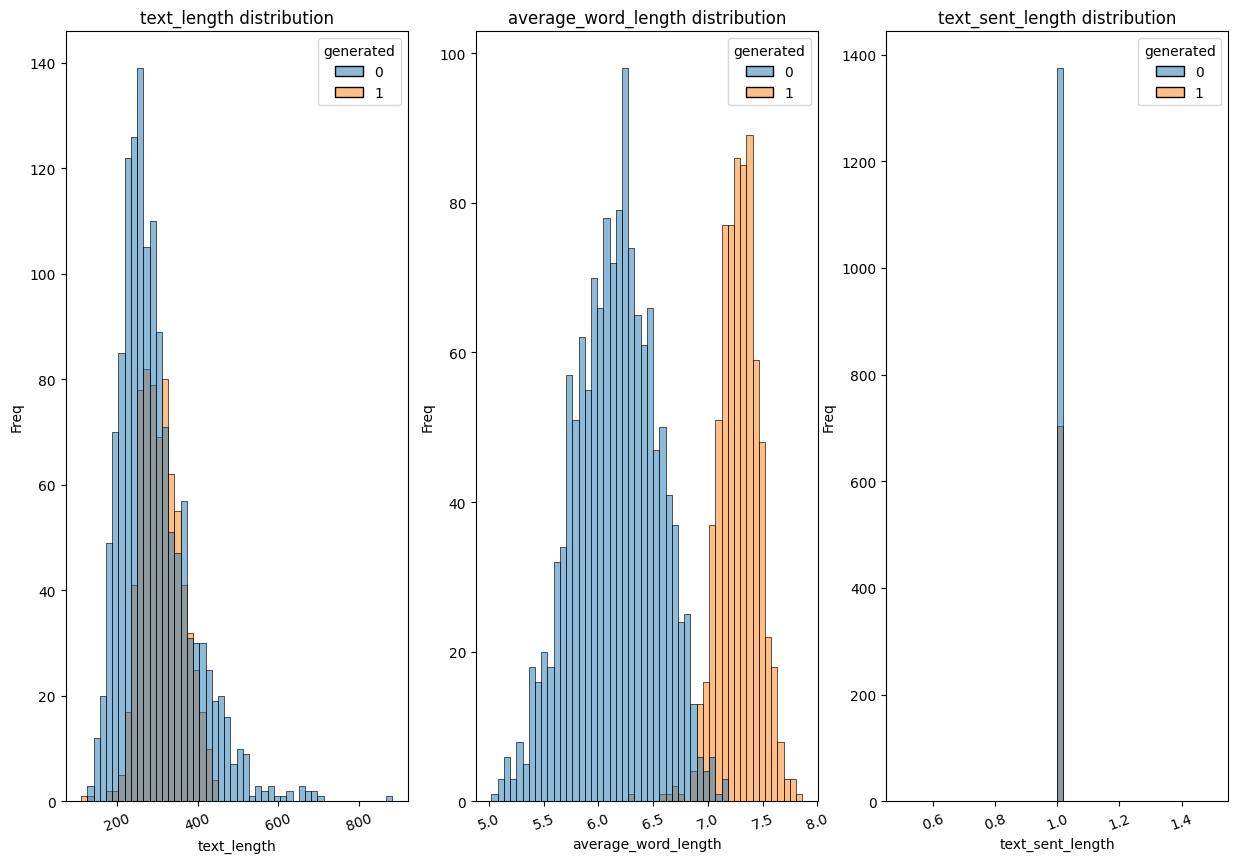

In [24]:
# Only 3 texts were generated :(
num_cols = df[['text_length', 'average_word_length', 'text_sent_length']].columns
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 10))
for ax, col in zip(axes.flatten(), num_cols):
    sns.histplot(data=df, x=df[col], hue='generated', ax=ax, bins=50)
    ax.set_title(f'{col} distribution')
    ax.set_xlabel(f'{col}')
    ax.set_ylabel('Freq')
    ax.tick_params(axis='x', labelrotation=20)

In [25]:
cnt = Counter()
df['BoW_raw'].apply(lambda x: ''.join(x)).apply(cnt.update)
cnt

Counter({'e': 556749,
         'a': 316431,
         't': 314651,
         's': 305637,
         'i': 295922,
         'n': 278784,
         'o': 274770,
         'r': 272435,
         'l': 233194,
         'c': 192198,
         'd': 137850,
         'p': 122537,
         'g': 120705,
         'u': 117947,
         'm': 98091,
         'v': 65029,
         'h': 64336,
         'y': 62610,
         'f': 48445,
         'b': 43942,
         'w': 42762,
         'k': 24039,
         'x': 6340,
         '0': 6195,
         'z': 4142,
         '2': 3940,
         'j': 3883,
         '1': 3731,
         'q': 3061,
         '5': 2050,
         '3': 1857,
         '9': 1262,
         '6': 1248,
         '7': 1116,
         '4': 1075,
         '8': 718})

In [26]:
df['BoW_lemmatized'] = df['BoW_raw'].apply(lemmatize)

In [27]:
df['tokens_num'] = df['BoW_lemmatized'].apply(len)

In [28]:
cnt_lemm = Counter()
df['BoW_lemmatized'].apply(cnt_lemm.update)
lemm_unigramms = cnt_lemm.most_common()
lemm_unigramms

[('car', 17010),
 ('electoral', 12925),
 ('vote', 11351),
 ('state', 10938),
 ('college', 10726),
 ('people', 7433),
 ('usage', 5238),
 ('president', 5115),
 ('election', 5051),
 ('candidate', 4959),
 ('would', 4063),
 ('system', 3887),
 ('popular', 3769),
 ('limiting', 3660),
 ('city', 3456),
 ('one', 3250),
 ('also', 3037),
 ('voter', 3034),
 ('elector', 2940),
 ('transportation', 2856),
 ('emission', 2634),
 ('day', 2632),
 ('air', 2598),
 ('many', 2568),
 ('pollution', 2535),
 ('gas', 2522),
 ('advantage', 2480),
 ('less', 2437),
 ('driving', 2360),
 ('even', 2299),
 ('way', 2261),
 ('get', 2218),
 ('community', 2189),
 ('smog', 2058),
 ('united', 2019),
 ('percent', 1983),
 ('use', 1955),
 ('need', 1899),
 ('environment', 1899),
 ('voting', 1877),
 ('like', 1874),
 ('could', 1867),
 ('make', 1865),
 ('source', 1860),
 ('greenhouse', 1841),
 ('world', 1840),
 ('time', 1823),
 ('country', 1777),
 ('paris', 1733),
 ('process', 1731),
 ('citizen', 1657),
 ('life', 1653),
 ('change', 1

In [29]:
cnt_lemm.most_common(20)

[('car', 17010),
 ('electoral', 12925),
 ('vote', 11351),
 ('state', 10938),
 ('college', 10726),
 ('people', 7433),
 ('usage', 5238),
 ('president', 5115),
 ('election', 5051),
 ('candidate', 4959),
 ('would', 4063),
 ('system', 3887),
 ('popular', 3769),
 ('limiting', 3660),
 ('city', 3456),
 ('one', 3250),
 ('also', 3037),
 ('voter', 3034),
 ('elector', 2940),
 ('transportation', 2856)]

In [30]:
unigrams = {key: value for key, value in lemm_unigramms}
unigrams

{'car': 17010,
 'electoral': 12925,
 'vote': 11351,
 'state': 10938,
 'college': 10726,
 'people': 7433,
 'usage': 5238,
 'president': 5115,
 'election': 5051,
 'candidate': 4959,
 'would': 4063,
 'system': 3887,
 'popular': 3769,
 'limiting': 3660,
 'city': 3456,
 'one': 3250,
 'also': 3037,
 'voter': 3034,
 'elector': 2940,
 'transportation': 2856,
 'emission': 2634,
 'day': 2632,
 'air': 2598,
 'many': 2568,
 'pollution': 2535,
 'gas': 2522,
 'advantage': 2480,
 'less': 2437,
 'driving': 2360,
 'even': 2299,
 'way': 2261,
 'get': 2218,
 'community': 2189,
 'smog': 2058,
 'united': 2019,
 'percent': 1983,
 'use': 1955,
 'need': 1899,
 'environment': 1899,
 'voting': 1877,
 'like': 1874,
 'could': 1867,
 'make': 1865,
 'source': 1860,
 'greenhouse': 1841,
 'world': 1840,
 'time': 1823,
 'country': 1777,
 'paris': 1733,
 'process': 1731,
 'citizen': 1657,
 'life': 1653,
 'change': 1626,
 'go': 1577,
 'public': 1555,
 'much': 1524,
 'may': 1522,
 'help': 1508,
 'benefit': 1507,
 'outcom

In [31]:
def get_words_as_text(tokens):
    return ' '.join(tokens)

In [32]:
words = df['BoW_raw'].apply(get_words_as_text)
words_as_texts = ' '.join(words)
all_words = words_as_texts.split()

In [33]:
bigrams = nltk.ngrams(all_words, 2)
cnt_bigrams = Counter(bigrams)
bigr = cnt_bigrams.most_common()

In [34]:
bigrams_freq = {' '.join(key): value for key, value in bigr}
bigrams_freq

{'electoral college': 10323,
 'car usage': 4736,
 'limiting car': 3260,
 'popular vote': 3083,
 'united states': 1973,
 'greenhouse gas': 1483,
 'gas emissions': 1427,
 'electoral votes': 1325,
 'swing states': 1048,
 'public transportation': 816,
 'college system': 807,
 'runoff elections': 791,
 'air pollution': 765,
 'advantages limiting': 740,
 'vote president': 698,
 'without cars': 677,
 'air quality': 658,
 'carfree day': 596,
 'certainty outcome': 544,
 'president united': 544,
 'many people': 527,
 'use cars': 517,
 'driving ban': 505,
 'elect president': 501,
 'city state': 501,
 'state zip': 497,
 'address city': 495,
 'vauban germany': 487,
 'election process': 459,
 'transregional appeal': 453,
 'alternative transportation': 450,
 'passenger cars': 447,
 'electoral vote': 433,
 'large states': 419,
 'vote system': 413,
 'reducing car': 413,
 'small states': 410,
 'cars responsible': 409,
 '60 percent': 409,
 'modes transportation': 399,
 'richard posner': 396,
 'around wor

In [35]:
trigrams = nltk.ngrams(all_words, 3)
cnt_trigrams = Counter(trigrams)
trigr = cnt_trigrams.most_common()

In [36]:
trigrams_freq = {' '.join(key): value for key, value in trigr}
trigrams_freq

{'limiting car usage': 3106,
 'greenhouse gas emissions': 1361,
 'electoral college system': 800,
 'advantages limiting car': 710,
 'president united states': 541,
 'city state zip': 497,
 'address city state': 495,
 'popular vote system': 390,
 'partial driving ban': 362,
 'election popular vote': 352,
 'passenger cars responsible': 336,
 'areas united states': 336,
 'electoral college ensures': 336,
 'electoral college unfair': 328,
 'percent greenhouse gas': 327,
 'alternative modes transportation': 316,
 'need runoff elections': 313,
 'name address city': 291,
 'reducing car usage': 288,
 '12 percent greenhouse': 283,
 'gas emissions europe': 283,
 'cars responsible 12': 276,
 'limit car usage': 271,
 'large small states': 270,
 'believe electoral college': 268,
 'carintensive areas united': 265,
 'car usage also': 262,
 'judge richard posner': 257,
 'indefensible electoral college': 253,
 'car always tense': 252,
 'responsible 12 percent': 251,
 'im much happier': 247,
 'conclusio

In [37]:
def get_pos(tokens):
    return [tag for word, tag in nltk.pos_tag(tokens, lang='eng')]

In [38]:
cnt_pos = Counter()
df['BoW_raw'].apply(get_pos).apply(cnt_pos.update)
pos_count = cnt_pos.most_common()
pos_count

[('NN', 198254),
 ('JJ', 113984),
 ('NNS', 96136),
 ('VBG', 36984),
 ('VBP', 35533),
 ('RB', 33799),
 ('VBD', 17458),
 ('VB', 16938),
 ('VBZ', 14638),
 ('CD', 14308),
 ('VBN', 10548),
 ('IN', 10418),
 ('MD', 8564),
 ('JJR', 5611),
 ('RBR', 2677),
 ('DT', 1829),
 ('PRP', 1398),
 ('JJS', 1052),
 ('RP', 494),
 ('CC', 326),
 ('FW', 158),
 ('NNP', 95),
 ('WDT', 88),
 ('RBS', 62),
 ('WP', 55),
 ('WRB', 40),
 ('WP$', 25),
 ('POS', 24),
 ('NNPS', 23),
 ('$', 19),
 ('TO', 18),
 ('UH', 17),
 ('EX', 9),
 ('PRP$', 6),
 ('SYM', 3),
 ('PDT', 1)]

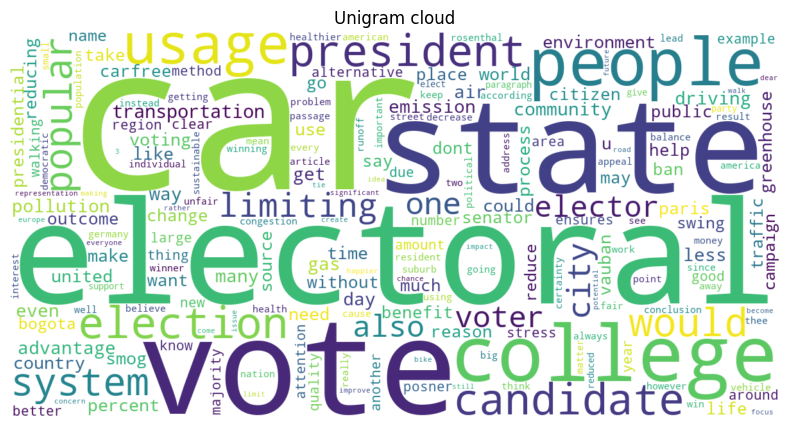

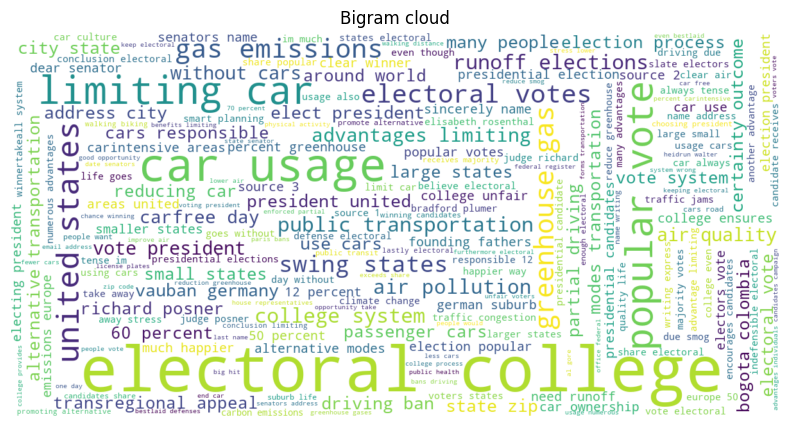

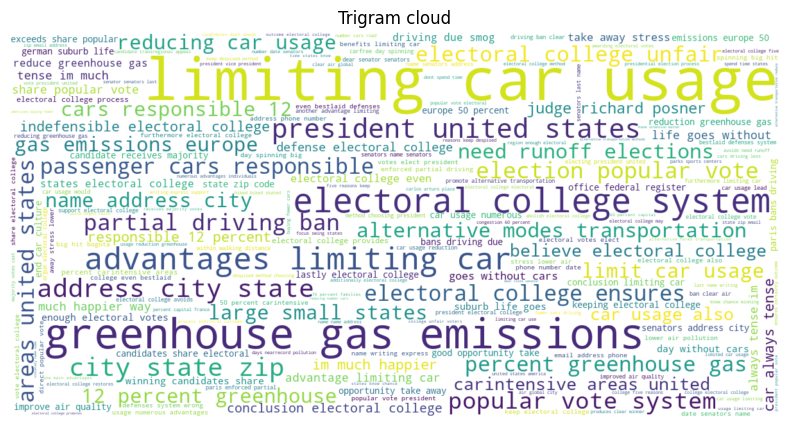

In [39]:
frequencies = unigrams, bigrams_freq, trigrams_freq
for feature in frequencies:
    wordcloud = WordCloud(width=1200, height=600, background_color='white').generate_from_frequencies(feature)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    if feature == unigrams:
        plt.title('Unigram cloud')
    elif feature == bigrams_freq:
        plt.title('Bigram cloud')
    else:
        plt.title('Trigram cloud')
    plt.axis('off')
    plt.show()

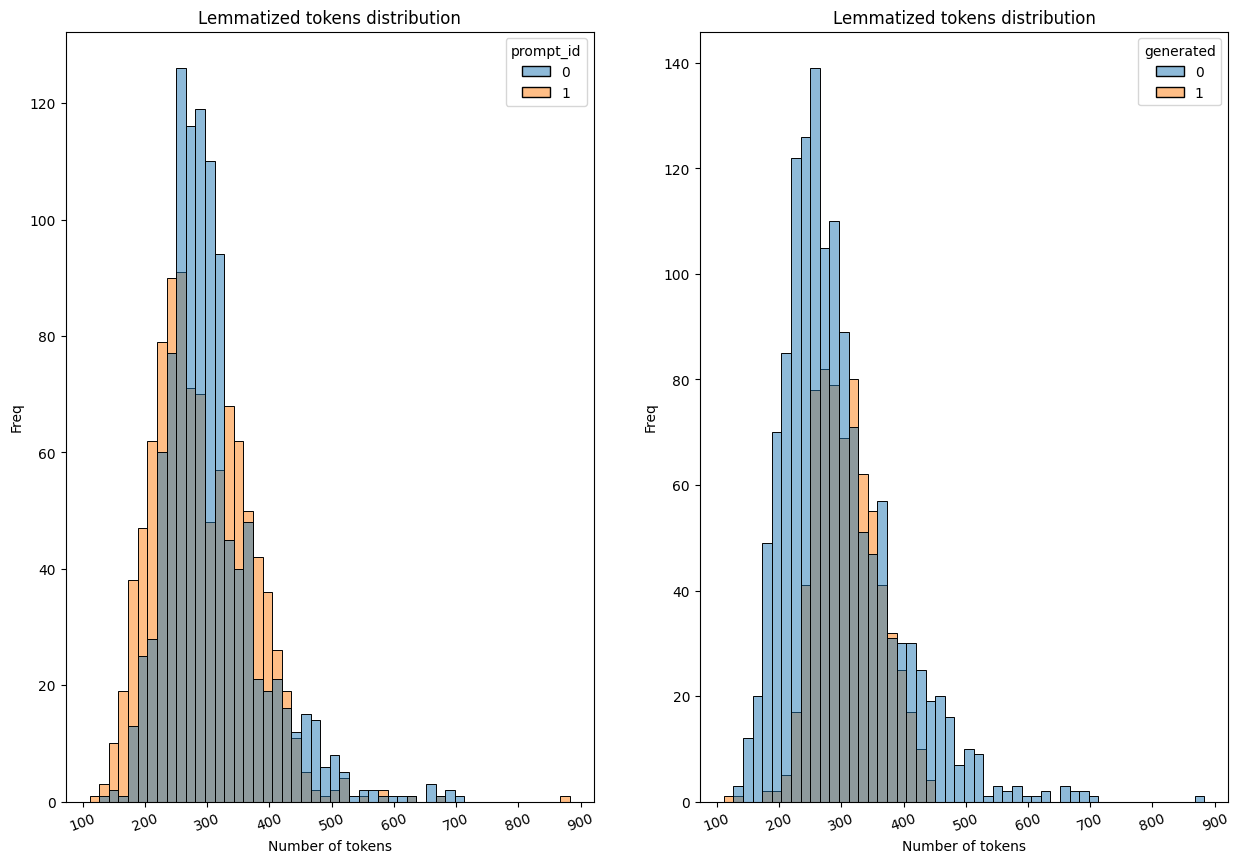

In [40]:
cols = ['prompt_id', 'generated']
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
for ax, col in zip(axes.flatten(), cols):
    sns.histplot(data=df, x=df['tokens_num'], hue=col, ax=ax, bins=50)
    ax.set_title('Lemmatized tokens distribution')
    ax.set_xlabel(f'Number of tokens')
    ax.set_ylabel('Freq')
    ax.tick_params(axis='x', labelrotation=20)

In [41]:
df

,prompt_id,text,generated,BoW_raw,text_length,average_word_length,text_sent_length,mean_sentence_length_chars,mean_sentence_length_words,BoW_lemmatized,tokens_num
0,0,cars cars around since became famous 1900s hen...,0,"[cars, cars, around, since, became, famous, 19...",324,5.84,1,"2,197.00",324.00,"[car, car, around, since, became, famous, 1900...",324
1,0,transportation large necessity countries world...,0,"[transportation, large, necessity, countries, ...",265,6.37,1,"1,924.00",265.00,"[transportation, large, necessity, country, wo...",265
2,0,americas love affair vehicles seems cooling sa...,0,"[americas, love, affair, vehicles, seems, cool...",411,6.48,1,"3,075.00",411.00,"[america, love, affair, vehicle, seems, coolin...",411
3,0,often ride car drive one motor vehicle work st...,0,"[often, ride, car, drive, one, motor, vehicle,...",376,6.14,1,"2,680.00",376.00,"[often, ride, car, drive, one, motor, vehicle,...",376
4,0,cars wonderful thing perhaps one worlds greate...,0,"[cars, wonderful, thing, perhaps, one, worlds,...",473,5.65,1,"3,126.00",473.00,"[car, wonderful, thing, perhaps, one, world, g...",473
...,...,...,...,...,...,...,...,...,...,...,...
2067,1,name address city state zip email address phon...,1,"[name, address, city, state, zip, email, addre...",357,7.46,1,"3,028.00",358.00,"[name, address, city, state, zip, email, addre...",357
2069,0,limiting car usage number advantages individua...,1,"[limiting, car, usage, number, advantages, ind...",279,7.41,1,"2,328.00",279.00,"[limiting, car, usage, number, advantage, indi...",279
2072,0,advantages limiting car usage limiting car usa...,1,"[advantages, limiting, car, usage, limiting, c...",333,7.16,1,"2,701.00",333.00,"[advantage, limiting, car, usage, limiting, ca...",333
2073,0,advantages limiting car usage becoming increas...,1,"[advantages, limiting, car, usage, becoming, i...",300,7.08,1,"2,404.00",300.00,"[advantage, limiting, car, usage, becoming, in...",300


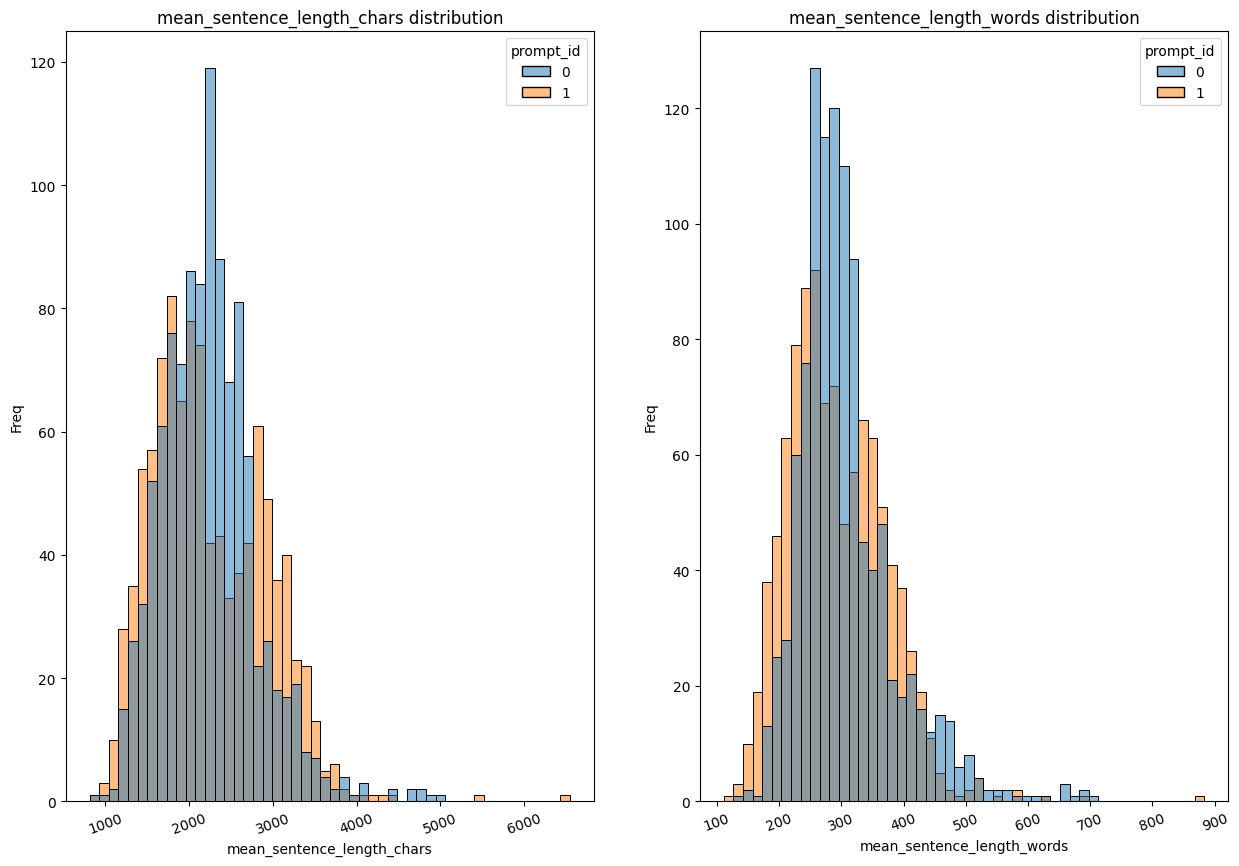

In [42]:
cols = df[['mean_sentence_length_chars', 'mean_sentence_length_words']].columns
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
for ax, col in zip(axes.flatten(), cols):
    sns.histplot(data=df, x=df[col], hue='prompt_id', ax=ax, bins=50)
    ax.set_title(f'{col} distribution')
    ax.set_xlabel(f'{col}')
    ax.set_ylabel('Freq')
    ax.tick_params(axis='x', labelrotation=20)

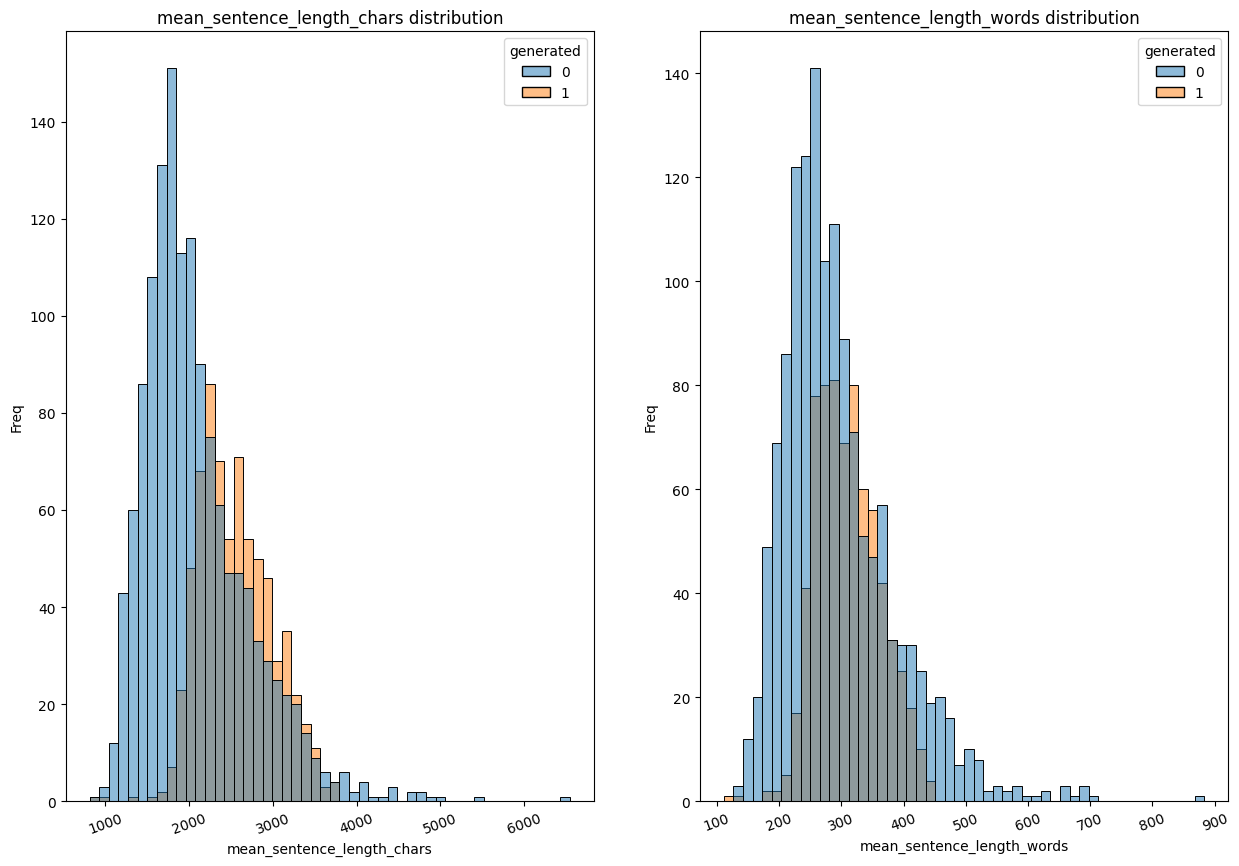

In [43]:
cols = df[['mean_sentence_length_chars', 'mean_sentence_length_words']].columns
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
for ax, col in zip(axes.flatten(), cols):
    sns.histplot(data=df, x=df[col], hue='generated', ax=ax, bins=50)
    ax.set_title(f'{col} distribution')
    ax.set_xlabel(f'{col}')
    ax.set_ylabel('Freq')
    ax.tick_params(axis='x', labelrotation=20)